HRNet with Simple centroid tracking

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff
import pickle

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths to your dataset in Google Drive
images_path = '/content/drive/MyDrive/Dataset for Computer Vision/Images'
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Properly initialize the parent class
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

# HRNet model definition
def hrnet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    maxpool1 = MaxPooling2D()(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(maxpool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    maxpool2 = MaxPooling2D()(conv4)

    conv5 = Conv2D(256, 3, activation='relu', padding='same')(maxpool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    maxpool3 = MaxPooling2D()(conv6)

    conv7 = Conv2D(512, 3, activation='relu', padding='same')(maxpool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv7)

    # Decoder
    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv10 = Conv2D(256, 3, activation='relu', padding='same')(conv9)

    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv12 = Conv2D(128, 3, activation='relu', padding='same')(conv11)

    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
hrmodel = hrnet_model(input_size=(256, 256, 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Set up data generators
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
test_gen = DataGenerator(test_images, test_masks)

# Train model
history = hrmodel.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

# Evaluate model on test data
test_loss, test_accuracy = hrmodel.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = hrmodel.predict(test_gen)


Mounted at /content/drive
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 771s 8s/step - accuracy: 0.8642 - loss: 0.4365 - val_accuracy: 0.8963 - val_loss: 0.3381
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.8966 - loss: 0.3362 - val_accuracy: 0.8942 - val_loss: 0.3494
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.8943 - loss: 0.3484 - val_accuracy: 0.8947 - val_loss: 0.3405
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 365ms/step - accuracy: 0.8922 - loss: 0.3455 - val_accuracy: 0.8930 - val_loss: 0.3427
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 371ms/step - accuracy: 0.8932 - loss: 0.3413 - val_accuracy: 0.8936 - val_loss: 0.3380
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.9000 - loss: 0.3255 - val_accuracy: 0.8948 - val_loss: 0.3401
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.8932 - loss: 0.3418 - val_accuracy: 0.8953 - val_loss: 0.3337
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 393ms/step - accuracy: 0.8970 - loss: 0.3333 - val_accuracy: 

In [ ]:
# Define file paths for saving the model, weights, and other outputs
model_save_path = '/content/drive/MyDrive/HRNet_model.h5'
weights_save_path = '/content/drive/MyDrive/HRNet.weights.h5'
history_save_path = '/content/drive/MyDrive/HRNet_training_history.pkl'
metrics_save_path = '/content/drive/MyDrive/HRNet_metrics.pkl'
predictions_save_path = '/content/drive/MyDrive/HRNet_test_predictions.npy'
y_true_save_path = '/content/drive/MyDrive/HRNet_y_true_flat.npy'
y_pred_save_path = '/content/drive/MyDrive/HRNet_y_pred_flat.npy'

# Save the entire model (architecture, weights, optimizer, and training state)
hrmodel.save(model_save_path)

# Save model weights separately (only weights)
hrmodel.save_weights(weights_save_path)

# Save the training history as a pickle file
with open(history_save_path, 'wb') as history_file:
    pickle.dump(history.history, history_file)

# Save evaluation metrics (test loss and test accuracy)
metrics = {"test_loss": test_loss, "test_accuracy": test_accuracy}
with open(metrics_save_path, 'wb') as metrics_file:
    pickle.dump(metrics, metrics_file)

# Save predictions (for the test set) as a NumPy array
np.save(predictions_save_path, y_pred)

# Save the flattened ground truth and predictions as NumPy arrays
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()

np.save(y_true_save_path, y_true_flat)
np.save(y_pred_save_path, y_pred_flat)

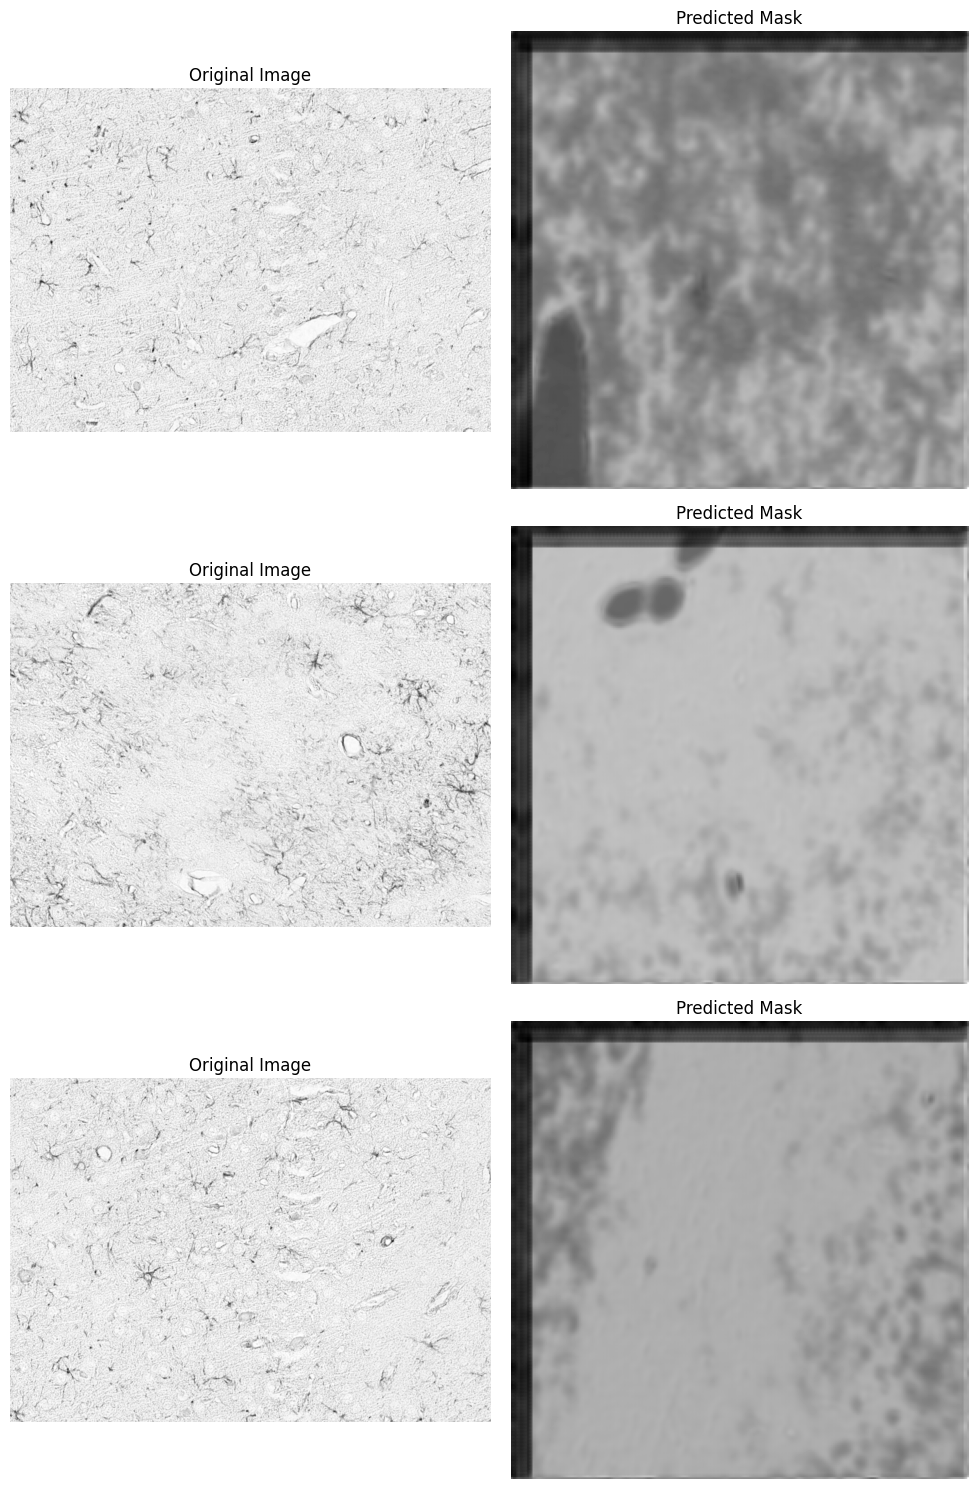

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import random

# Load the saved predictions and ground truth labels
y_pred = np.load('/content/drive/MyDrive/HRNet_test_predictions.npy')

# Ensure predictions are binary (0 or 1)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Function to load TIFF images from the file path
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Visualization function using original images
def visualize_segmentation(image_paths, y_pred, num_samples=3):
    # Ensure we do not exceed the number of predictions
    num_images = min(len(image_paths), len(y_pred))
    indices = random.sample(range(num_images), num_samples)

    plt.figure(figsize=(10, num_samples * 5))

    for i, idx in enumerate(indices):
        # Load the original image
        img = load_tiff_image(image_paths[idx])
        pred_mask = y_pred[idx, :, :, 0]  # Ensure index does not go out of bounds

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title("Original Image")
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load your test images paths (update the path if needed)
test_images_path = '/content/drive/MyDrive/Dataset for Computer Vision/Images'
test_images = sorted([os.path.join(test_images_path, file) for file in os.listdir(test_images_path) if file.endswith('.tif')])

# Visualize a few samples with their predicted masks
visualize_segmentation(test_images, y_pred)


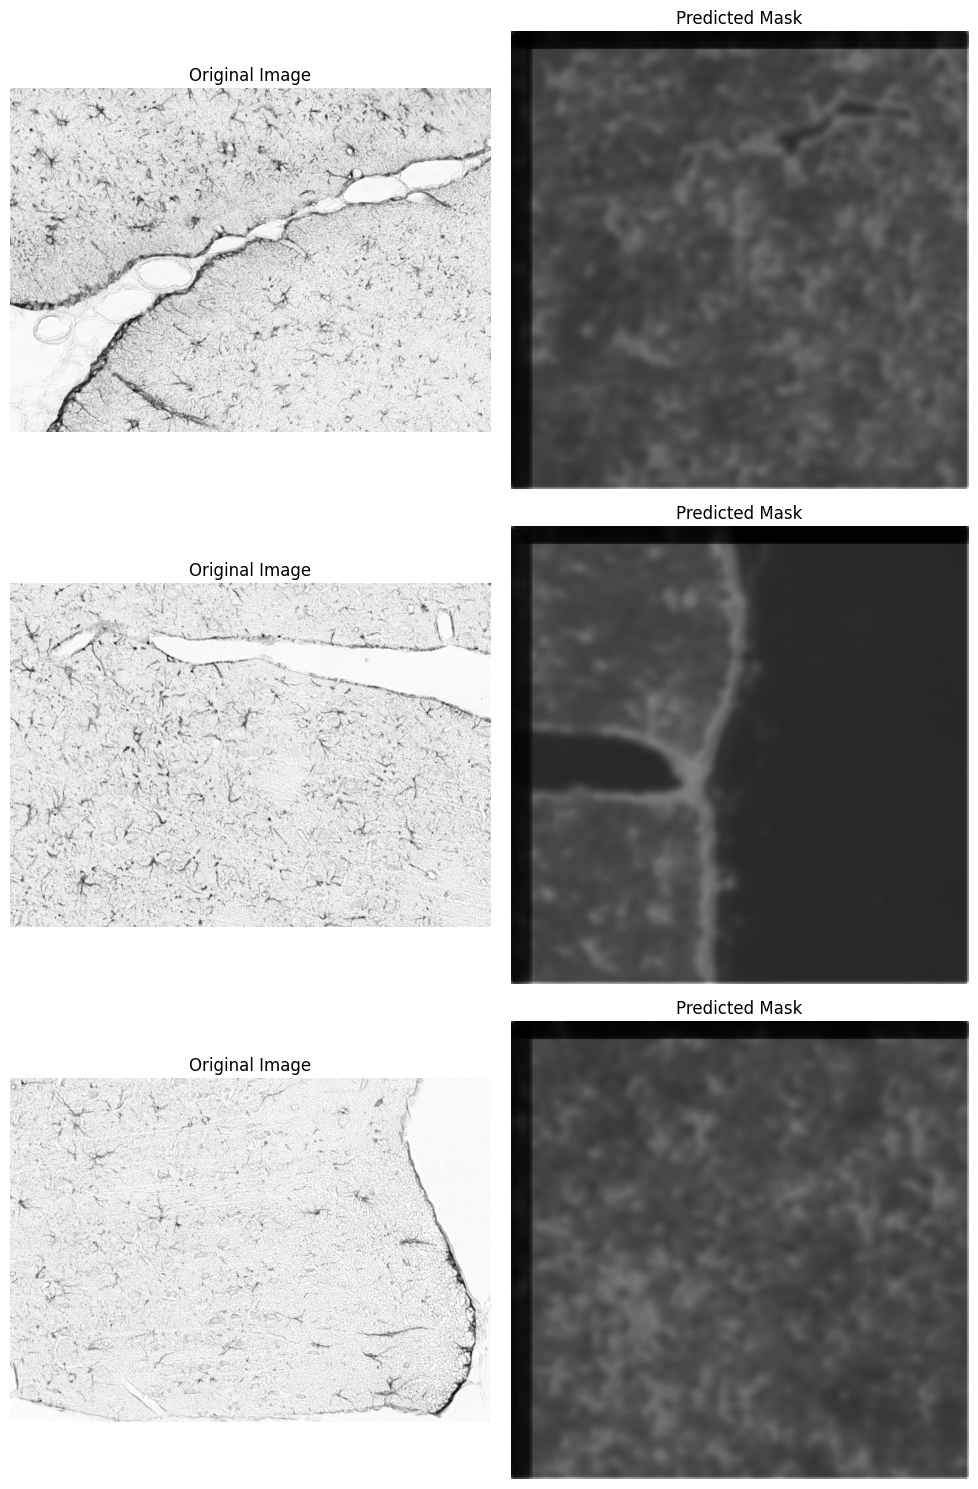

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import random

# Load the saved predictions and ground truth labels
y_pred = np.load('/content/drive/MyDrive/UNet3plus_test_predictions.npy')

# Ensure predictions are binary (0 or 1)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Function to load TIFF images from the file path
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Visualization function using original images
def visualize_segmentation(image_paths, y_pred, num_samples=3):
    # Ensure we do not exceed the number of predictions
    num_images = min(len(image_paths), len(y_pred))
    indices = random.sample(range(num_images), num_samples)

    plt.figure(figsize=(10, num_samples * 5))

    for i, idx in enumerate(indices):
        # Load the original image
        img = load_tiff_image(image_paths[idx])
        pred_mask = y_pred[idx, :, :, 0]  # Ensure index does not go out of bounds

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title("Original Image")
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load your test images paths (update the path if needed)
test_images_path = '/content/drive/MyDrive/Dataset for Computer Vision/Images'
test_images = sorted([os.path.join(test_images_path, file) for file in os.listdir(test_images_path) if file.endswith('.tif')])

# Visualize a few samples with their predicted masks
visualize_segmentation(test_images, y_pred)


HRNet with Simple centroid tracking metrics

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/HRNet_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))
    return cell_data

# Function to load all ground truth centroids
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Centroid extraction from masks
def get_centroids(mask):
    mask = (mask > 0.1).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Tracking logic
def track_cells(previous_centroids, current_centroids, max_distance=50):
    matches = {}
    current_centroids_copy = current_centroids.copy()
    for prev in previous_centroids:
        min_dist = float('inf')
        best_match = None
        best_match_index = -1
        for i, curr in enumerate(current_centroids_copy):
            dist = distance.euclidean(prev, curr)
            if dist < min_dist and dist <= max_distance:
                min_dist = dist
                best_match = curr
                best_match_index = i
        if best_match is not None:
            matches[prev] = best_match
            current_centroids_copy.pop(best_match_index)
    return matches

# Metrics definitions
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))
        current_centroids = set(map(tuple, tracked_centroids[i]))
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)
    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Load ground truths and process masks
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'
true_centroids_list = load_all_ground_truths(masks_path)
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []

# Track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Compute metrics
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_false_discovery_rate = false_discovery_rate(tracked_centroids, true_centroids_list)

# Print results
print(f"Track Consistency: {average_track_consistency}")
print(f"Jaccard Index: {average_jaccard_index}")
print(f"Mean Squared Error: {average_mse}")
print(f"MOTA: {average_mota}")
print(f"MOTP: {average_motp}")
print(f"ID F1 Score: {average_id_f1_score}")
print(f"Tracking Error: {average_tracking_error}")
print(f"False Discovery Rate: {average_false_discovery_rate}")


Track Consistency: 0.28475336322869954
Jaccard Index: 0.0
Mean Squared Error: 319050.06540062715
MOTA: 0.5883648008539596
MOTP: 46.513135832470155
ID F1 Score: 0.0021445421402530563
Tracking Error: 517.9599947034702
False Discovery Rate: 1.0


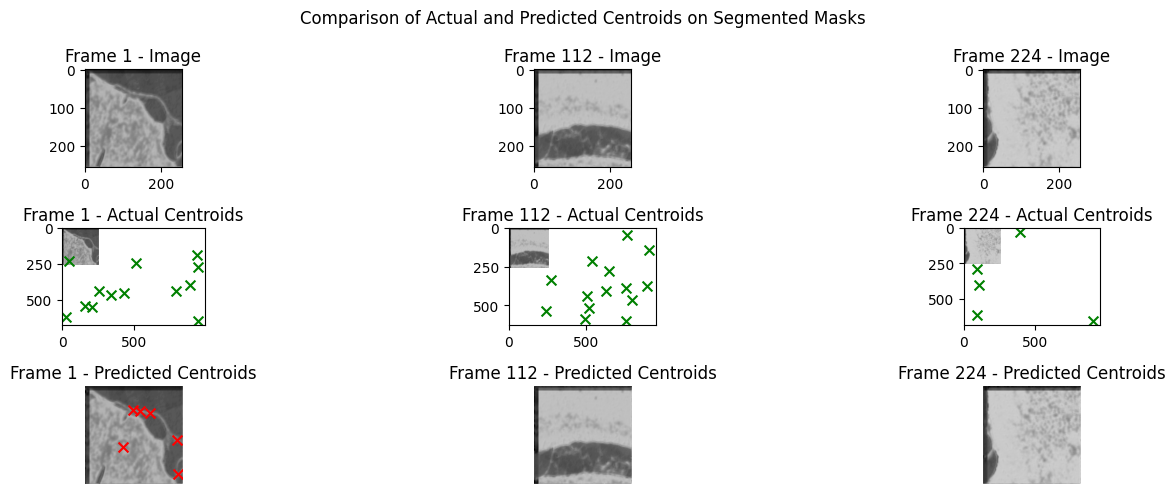

In [ ]:
# Function to visualize centroids on frames
def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx]

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = track_cells(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)

HRNet with Kalman filter tracking metrics

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/HRNet_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))
    return cell_data

# Function to load all ground truth centroids
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Centroid extraction from masks
def get_centroids(mask):
    mask = (mask > 0.1).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Kalman Filter class for tracking
class KalmanTracker:
    def __init__(self, centroid):
        self.kalman = cv2.KalmanFilter(4, 2)
        self.kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                                  [0, 1, 0, 0]], np.float32)
        self.kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                                 [0, 1, 0, 1],
                                                 [0, 0, 1, 0],
                                                 [0, 0, 0, 1]], np.float32)
        self.kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
        self.kalman.statePre = np.array([[centroid[0]], [centroid[1]], [0], [0]], np.float32)
        self.kalman.statePost = np.array([[centroid[0]], [centroid[1]], [0], [0]], np.float32)

    def update(self, centroid=None):
        if centroid is not None:
            measurement = np.array([[np.float32(centroid[0])], [np.float32(centroid[1])]])
            self.kalman.correct(measurement)
        prediction = self.kalman.predict()
        return (int(prediction[0]), int(prediction[1]))

# Kalman filter based tracking function
def track_cells_kalman(previous_centroids, current_centroids, kalman_filters):
    matches = {}
    for i, kf in enumerate(kalman_filters):
        pred = kf.predict()
        min_distance = float('inf')
        closest_centroid = None
        closest_idx = None
        for j, current_centroid in enumerate(current_centroids):
            dist = distance.euclidean((pred[0], pred[1]), current_centroid)
            if dist < min_distance:
                min_distance = dist
                closest_centroid = current_centroid
                closest_idx = j
        if closest_centroid is not None:
            # Convert the centroid (which is a numpy.ndarray) to a tuple for use as a dict key
            matches[tuple(pred[:2])] = tuple(closest_centroid)
            current_centroids.pop(closest_idx)
            kf.correct(np.array([[closest_centroid[0]], [closest_centroid[1]]], np.float32))

    # Create new Kalman filters for unmatched centroids
    for new_centroid in current_centroids:
        kalman_filters.append(initialize_kalman_filter(new_centroid))
        matches[tuple(new_centroid)] = tuple(new_centroid)  # Ensure the key is a tuple

    return matches, kalman_filters

# Metrics definitions
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))
        current_centroids = set(map(tuple, tracked_centroids[i]))
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)
    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Load ground truths and process masks
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'
true_centroids_list = load_all_ground_truths(masks_path)
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []

# Track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Compute metrics
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_false_discovery_rate = false_discovery_rate(tracked_centroids, true_centroids_list)

# Print results
print(f"Track Consistency: {average_track_consistency}")
print(f"Jaccard Index: {average_jaccard_index}")
print(f"Mean Squared Error: {average_mse}")
print(f"MOTA: {average_mota}")
print(f"MOTP: {average_motp}")
print(f"ID F1 Score: {average_id_f1_score}")
print(f"Tracking Error: {average_tracking_error}")
print(f"False Discovery Rate: {average_false_discovery_rate}")


Track Consistency: 0.28475336322869954
Jaccard Index: 0.0
Mean Squared Error: 319050.06540062715
MOTA: 0.5883648008539596
MOTP: 46.513135832470155
ID F1 Score: 0.0021445421402530563
Tracking Error: 517.9599947034702
False Discovery Rate: 1.0


In [ ]:
import matplotlib.pyplot as plt

def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx]

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

# Track cells across frames
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    if frame_idx == 0:
        # For the first frame, initialize with predicted centroids
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matches, kalman_filters = track_cells_kalman(previous_centroids, current_centroids, kalman_filters)
        tracked_centroids.append(list(matches.values()))  # Update tracked centroids

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)


ValueError: shapes (2,4) and (2,) not aligned: 4 (dim 1) != 2 (dim 0)

HRNet with nearest neighbour tracking metrics

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/HRNet_test_predictions.npy')

# Parse cell data for ground truth
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))
    return cell_data

# Load all ground truth centroids
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Centroid extraction from masks
def get_centroids(mask):
    mask = (mask > 0.1).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Nearest Neighbor Tracking
def nearest_neighbor_tracking(previous_centroids, current_centroids, max_distance=50):
    matched_centroids = []
    unmatched_previous = set(previous_centroids)
    unmatched_current = set(current_centroids)

    for prev in previous_centroids:
        closest_distance = float('inf')
        closest_centroid = None
        for curr in current_centroids:
            dist = distance.euclidean(prev, curr)
            if dist < closest_distance and dist <= max_distance:
                closest_distance = dist
                closest_centroid = curr

        if closest_centroid is not None:
            matched_centroids.append(closest_centroid)
            unmatched_current.discard(closest_centroid)
            unmatched_previous.discard(prev)

    matched_centroids.extend(unmatched_previous)  # Carry forward unmatched previous centroids
    matched_centroids.extend(unmatched_current)  # Add unmatched current centroids as new detections

    return matched_centroids

# Metrics definitions
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))
        current_centroids = set(map(tuple, tracked_centroids[i]))
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)
    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Load ground truths and process masks
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'
true_centroids_list = load_all_ground_truths(masks_path)
segmented_masks = [mask.squeeze() for mask in y_pred]

# Track centroids using Nearest Neighbor Tracking
tracked_centroids = []
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Compute metrics
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_false_discovery_rate = false_discovery_rate(tracked_centroids, true_centroids_list)

# Print results
print(f"Track Consistency: {average_track_consistency}")
print(f"Jaccard Index: {average_jaccard_index}")
print(f"Mean Squared Error: {average_mse}")
print(f"MOTA: {average_mota}")
print(f"MOTP: {average_motp}")
print(f"ID F1 Score: {average_id_f1_score}")
print(f"Tracking Error: {average_tracking_error}")
print(f"False Discovery Rate: {average_false_discovery_rate}")


Track Consistency: 0.8204624094653296
Jaccard Index: 0.0
Mean Squared Error: 286447.74640877167
MOTA: -1.938955233838148
MOTP: 0
ID F1 Score: 0
Tracking Error: 526.6514685330682
False Discovery Rate: 1.0


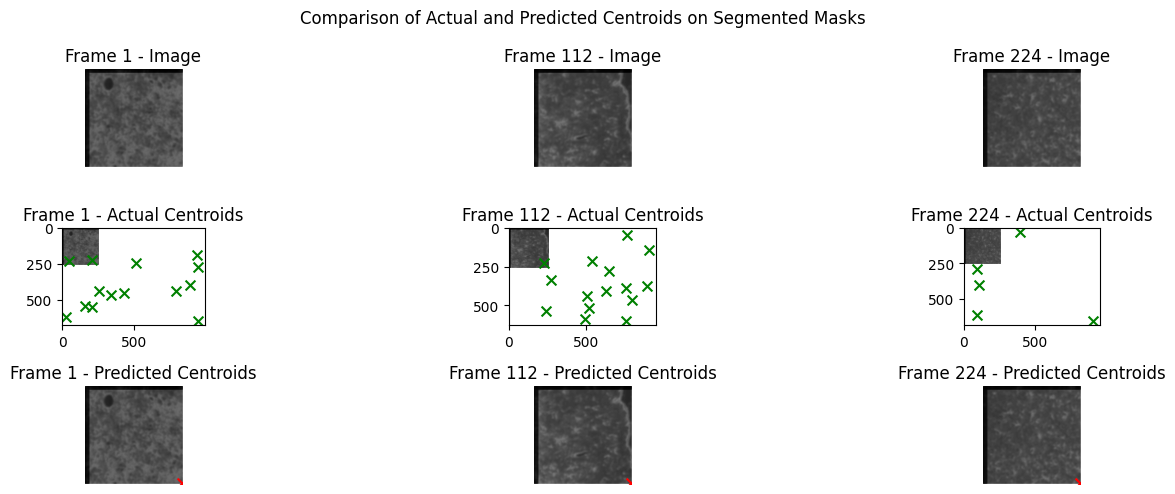

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize centroids on frames
def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))

    # Select frames to visualize
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')
        plt.axis('off')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)


# UNet3+ models

Unet3+ loading

In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

# Set paths to your dataset in Google Drive
images_path = '/content/drive/MyDrive/Dataset for Computer Vision/Images'
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

# Define UNet3+ model
def unet3plus_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)

    upconv3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    merge3 = concatenate([upconv3_1, conv3_2], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(merge3)
    conv3_4 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)

    upconv2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_4)
    merge2 = concatenate([upconv2_1, conv2_2], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)

    upconv1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_4)
    merge1 = concatenate([upconv1_1, conv1_2], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv1_4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize UNet3+ model
unet3model = unet3plus_model(input_size=(256, 256, 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Set up data generators
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
test_gen = DataGenerator(test_images, test_masks)

# Train the UNet3+ model
history = unet3model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

# Evaluate model on test data
test_loss, test_accuracy = unet3model.evaluate(test_gen)
y_pred = unet3model.predict(test_gen)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.8565 - loss: 0.5064 - val_accuracy: 0.8959 - val_loss: 0.3338
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.8983 - loss: 0.3300 - val_accuracy: 0.8935 - val_loss: 0.3419
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 371ms/step - accuracy: 0.8954 - loss: 0.3358 - val_accuracy: 0.8943 - val_loss: 0.3349
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.8994 - loss: 0.3240 - val_accuracy: 0.8948 - val_loss: 0.3328
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 382ms/step - accuracy: 0.8901 - loss: 0.3452 - val_accuracy: 0.8945 - val_loss: 0.3346
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.9040 - loss: 0.3157 - val_accuracy: 0.8954 - val_loss: 0.3448
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 391ms/step - accuracy: 0.9042 - loss: 0.3246 - val_accuracy: 0.8942 - val_loss: 0.3370
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.8973 - loss: 0.3303 - val_accuracy

In [ ]:
# Define file paths for saving the model, weights, and other outputs
unet3_model_save_path = '/content/drive/MyDrive/UNet3plus_model.h5'
unet3_weights_save_path = '/content/drive/MyDrive/UNet3plus.weights.h5'
unet3_history_save_path = '/content/drive/MyDrive/UNet3plus_training_history.pkl'
unet3_metrics_save_path = '/content/drive/MyDrive/UNet3plus_metrics.pkl'
unet3_predictions_save_path = '/content/drive/MyDrive/UNet3plus_test_predictions.npy'
unet3_y_true_save_path = '/content/drive/MyDrive/UNet3plus_y_true_flat.npy'
unet3_y_pred_save_path = '/content/drive/MyDrive/UNet3plus_y_pred_flat.npy'

# Save the entire model (architecture, weights, optimizer, and training state)
unet3model.save(unet3_model_save_path)

# Save model weights separately (only weights)
unet3model.save_weights(unet3_weights_save_path)

# Save the training history as a pickle file
with open(unet3_history_save_path, 'wb') as history_file:
    pickle.dump(history.history, history_file)

# Save evaluation metrics (test loss and test accuracy)
unet3_metrics = {"test_loss": test_loss, "test_accuracy": test_accuracy}
with open(unet3_metrics_save_path, 'wb') as metrics_file:
    pickle.dump(unet3_metrics, metrics_file)

# Save predictions (for the test set) as a NumPy array
np.save(unet3_predictions_save_path, y_pred)

# Save the flattened ground truth and predictions as NumPy arrays
unet3_y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
unet3_y_pred_flat = y_pred.flatten()

np.save(unet3_y_true_save_path, unet3_y_true_flat)
np.save(unet3_y_pred_save_path, unet3_y_pred_flat)


UNet3+ simple centroid metrics

In [ ]:
import numpy as np
import cv2
from scipy.spatial import distance
import os

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/UNet3plus_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                # Extract the centroid from ground truth annotations
                x1, y1, x2, y2 = int(parts[4]), int(parts[5]), int(parts[6]), int(parts[7])
                # Calculate centroid
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))  # Store centroid
    return cell_data

# Function to load all ground truth centroids (assuming they are in separate txt files)
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):  # Assuming files are sorted by frame number
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Function to extract centroids from U-Net segmentation mask
def get_centroids(mask):
    mask = (mask * 255).astype(np.uint8)  # Adjusted threshold for better segmentation
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        if cv2.contourArea(contour) > 10:  # Adjusted contour area threshold
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                centroids.append((cX, cY))
    return centroids

# Tracking logic
def track_cells(previous_centroids, current_centroids, max_distance=50):
    matches = {}
    current_centroids_copy = current_centroids.copy()
    for prev in previous_centroids:
        min_dist = float('inf')
        best_match = None
        best_match_index = -1
        for i, curr in enumerate(current_centroids_copy):
            dist = distance.euclidean(prev, curr)
            if dist < min_dist and dist <= max_distance:
                min_dist = dist
                best_match = curr
                best_match_index = i
        if best_match is not None:
            matches[prev] = best_match
            current_centroids_copy.pop(best_match_index)
    return matches

# Track Consistency Function
def track_consistency(tracked_centroids):
    if not tracked_centroids:
        return 0
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))  # Convert to tuple for set operation
        current_centroids = set(map(tuple, tracked_centroids[i]))  # Convert to tuple for set operation
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

# Jaccard Index
def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

# Mean Squared Error (MSE)
def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

# Multiple Object Tracking Accuracy (MOTA)
def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)

    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

# Multiple Object Tracking Precision (MOTP)
def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

# ID F1 Score
def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Tracking Error (Euclidean Distance)
def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

# False Discovery Rate (FDR)
def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]  # U-Net model outputs the masks here
previous_centroids = []
tracked_centroids = []

# Assuming true_centroids_list is available for comparison
# Process frames to track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    if current_centroids and true_centroids:  # Only add frames with valid centroids
        # Store the centroids of the current frame for tracking overview
        tracked_centroids.append(current_centroids)
        previous_centroids = current_centroids

# Compute all metrics, excluding frames without valid centroids
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list) if pred and true])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list) if pred and true])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_fdr = false_discovery_rate(tracked_centroids, true_centroids_list)

# Output the results
print(f"Track Consistency: {average_track_consistency:.4f}")
print(f"Jaccard Index: {average_jaccard_index:.4f}")
print(f"MSE: {average_mse:.4f}")
print(f"MOTA: {average_mota:.4f}")
print(f"MOTP: {average_motp:.4f}")
print(f"ID F1 Score: {average_id_f1_score:.4f}")
print(f"Tracking Error: {average_tracking_error:.4f}")
print(f"False Discovery Rate (FDR): {average_fdr:.4f}")


Track Consistency: 0.9193
Jaccard Index: 0.0000
MSE: 364855.4710
MOTA: 0.7829
MOTP: 0.0000
ID F1 Score: 0.0000
Tracking Error: 561.7705
False Discovery Rate (FDR): 1.0000


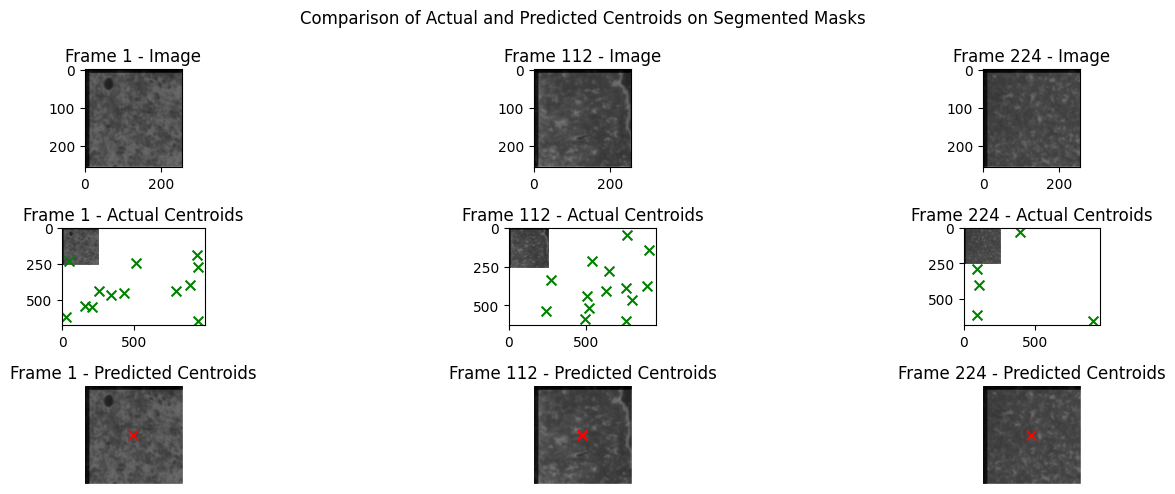

In [ ]:
# Function to visualize centroids on frames
def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx]

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = track_cells(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)

UNet3+ Kalman filter metrics

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/UNet3plus_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell_id = int(parts[1])  # cell ID (if needed)
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])

                # Calculate centroid
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))  # Store centroid
    return cell_data

# Function to load all ground truth centroids (assuming they are in separate txt files)
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Example usage: Load all ground truth centroids from the directory
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'
true_centroids_list = load_all_ground_truths(masks_path)
print(true_centroids_list)

# Post-processing: Cell Tracking
def get_centroids(mask):
    mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Initialize Kalman Filter for tracking
def initialize_kalman_filter():
    kalman = cv2.KalmanFilter(4, 2)  # 4 state variables (x, y, velocity_x, velocity_y), 2 measurements (x, y)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                        [0, 1, 0, 1],
                                        [0, 0, 1, 0],
                                        [0, 0, 0, 1]], dtype=np.float32)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                         [0, 1, 0, 0]], dtype=np.float32)
    kalman.processNoiseCov = np.array([[1e-5, 0, 0, 0],
                                       [0, 1e-5, 0, 0],
                                       [0, 0, 1e-5, 0],
                                       [0, 0, 0, 1e-5]], dtype=np.float32)
    kalman.measurementNoiseCov = np.array([[1e-1, 0],
                                           [0, 1e-1]], dtype=np.float32)
    kalman.errorCovPost = np.eye(4, dtype=np.float32)
    return kalman

# Track cells using Kalman Filter
def track_cells_kalman(previous_centroids, current_centroids, kalman_filters, max_distance=50):
    matches = {}
    current_centroids_copy = current_centroids.copy()  # Avoid modifying the original list

    for prev_idx, prev in enumerate(previous_centroids):
        # Predict the next position using the Kalman filter
        kalman_filter = kalman_filters[prev_idx]
        predicted = kalman_filter.predict()

        predicted_centroid = np.array([predicted[0][0], predicted[1][0]])

        # Find the closest true centroid to the predicted position
        min_dist = float('inf')
        best_match = None
        best_match_index = -1
        for i, curr in enumerate(current_centroids_copy):
            dist = distance.euclidean(predicted_centroid, np.array(curr))
            if dist < min_dist and dist <= max_distance:
                min_dist = dist
                best_match = curr
                best_match_index = i

        if best_match is not None:
            matches[tuple(prev)] = best_match  # Store match by previous centroid
            current_centroids_copy.pop(best_match_index)
            kalman_filter.correct(np.array([[np.float32(best_match[0])], [np.float32(best_match[1])]]))

    return matches, kalman_filters


# Evaluation metrics

def track_consistency(pred_centroids_list, true_centroids_list):
    consistency = []
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        if not pred_centroids or not true_centroids:
            consistency.append(0)
            continue
        pred_set = set(map(tuple, pred_centroids))
        true_set = set(map(tuple, true_centroids))
        matches = pred_set.intersection(true_set)
        consistency_frame = len(matches) / max(len(pred_set), len(true_set)) if max(len(pred_set), len(true_set)) > 0 else 0
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

def jaccard_index(pred_centroids, true_centroids):
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

def mse_centroids(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    min_length = min(len(pred_centroids), len(true_centroids))
    pred_centroids = pred_centroids[:min_length]
    true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(pred, true)**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                matches += 1
                unmatched_true.remove(pred_tuple)
            else:
                FP += 1
        FN += len(unmatched_true)
        IDS += abs(len(pred_centroids) - matches)
    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                unmatched_true.remove(pred_tuple)
                total_dist += distance.euclidean(pred, pred_tuple)
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                TP += 1
                unmatched_true.remove(pred_tuple)
            else:
                FP += 1
        FN += len(unmatched_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP = 0
    total_pred = sum(len(pred) for pred in pred_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_pred = set(map(tuple, pred_centroids))
        unmatched_true = set(map(tuple, true_centroids))
        FP += len(unmatched_pred.difference(unmatched_true))
    return FP / total_pred if total_pred > 0 else 0


# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []
kalman_filters = []

# Initialize Kalman Filters for the first frame
for _ in range(len(true_centroids_list[0])):  # Assuming the first frame has the same number of centroids as the predicted
    kalman_filters.append(initialize_kalman_filter())

# Process frames to track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    # Track cells with Kalman Filter
    matches, kalman_filters = track_cells_kalman(previous_centroids, current_centroids, kalman_filters)

    # Store the centroids of the current frame for tracking overview
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Print tracked centroids for each frame
print("Tracked centroids across frames:")
for i, centroids in enumerate(tracked_centroids):
    print(f"Frame {i + 1}: {centroids}")

# Compute metrics
print("Tracking Metrics:")
print(f"Consistency: {track_consistency(tracked_centroids, true_centroids_list)}")
print(f"Jaccard Index: {jaccard_index(tracked_centroids[-1], true_centroids_list[-1])}")
print(f"MSE: {mse_centroids(tracked_centroids[-1], true_centroids_list[-1])}")
print(f"MOTA: {mota(tracked_centroids, true_centroids_list)}")
print(f"MOTP: {motp(tracked_centroids, true_centroids_list)}")
print(f"ID F1 Score: {id_f1_score(tracked_centroids, true_centroids_list)}")
print(f"Tracking Error: {tracking_error(tracked_centroids, true_centroids_list)}")
print(f"False Discovery Rate: {false_discovery_rate(tracked_centroids, true_centroids_list)}")


[[(793.0, 440.0), (29.0, 620.0), (938.0, 185.0), (945.0, 272.0), (945.0, 647.0), (892.0, 398.5), (515.0, 241.5), (429.5, 453.5), (337.5, 464.0), (257.0, 437.0), (205.0, 550.5), (160.0, 545.0), (47.5, 229.5), (210.0, 223.5)], [(895.5, 404.0), (802.5, 34.0), (674.5, 506.5), (661.5, 191.5), (147.0, 32.0), (27.0, 319.5), (958.0, 268.0), (401.0, 108.0)], [(390.0, 399.0), (671.0, 551.0), (214.0, 678.0), (421.5, 186.5), (549.0, 30.5), (91.5, 640.0), (662.0, 135.0), (395.5, 512.0), (544.5, 462.0), (946.0, 586.5), (30.0, 393.5), (128.0, 299.5), (871.5, 637.5)], [(117.0, 317.5), (75.5, 265.0), (205.0, 560.5), (408.0, 506.5), (495.5, 441.5), (761.5, 40.0), (656.5, 366.0), (76.5, 414.5), (692.0, 491.0), (511.5, 538.5)], [(878.0, 446.5), (51.5, 563.0), (35.5, 611.0), (887.5, 654.0), (894.0, 205.5), (826.5, 318.0), (650.0, 670.5), (151.0, 655.5), (209.5, 484.5), (353.5, 618.0), (366.0, 509.0), (424.0, 415.0), (489.5, 300.5), (330.5, 27.0), (331.0, 150.0), (278.5, 92.5), (226.5, 130.5), (194.0, 310.0

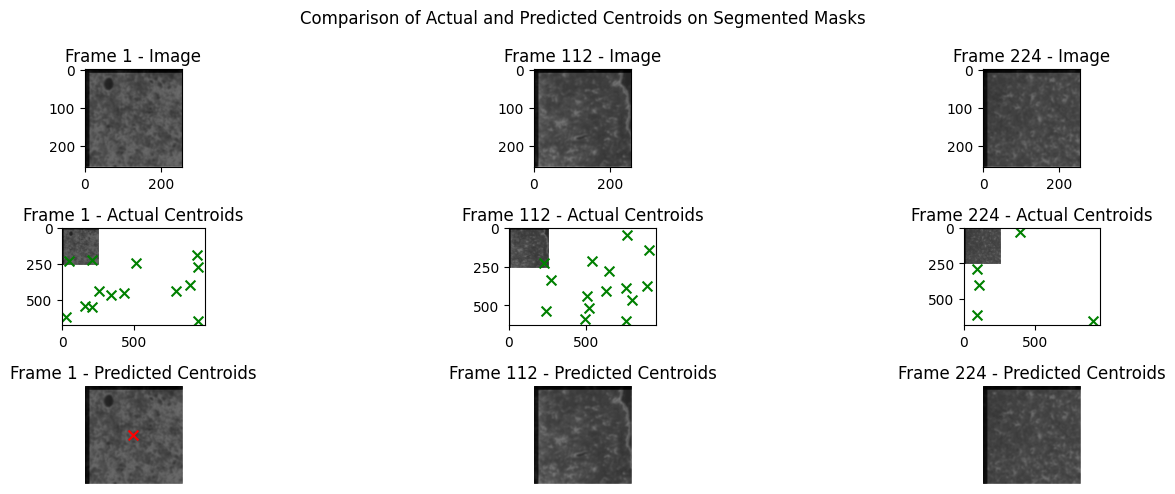

In [ ]:
import matplotlib.pyplot as plt

def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx]

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

# Initialize Kalman Filters for the first frame
kalman_filters = [initialize_kalman_filter() for _ in range(len(true_centroids_list[0]))]

# Track cells across frames
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    if frame_idx == 0:
        # For the first frame, initialize with predicted centroids
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matches, kalman_filters = track_cells_kalman(previous_centroids, current_centroids, kalman_filters)
        tracked_centroids.append(list(matches.values()))  # Update tracked centroids

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)


UNet3+ nearest neighbour metrics

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/UNet3plus_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])

                # Calculate centroid
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))  # Store centroid
    return cell_data

# Function to load all ground truth centroids (assuming they are in separate txt files)
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Example usage: Load all ground truth centroids from the directory
masks_path = '/content/drive/MyDrive/Dataset for Computer Vision/Masks'
true_centroids_list = load_all_ground_truths(masks_path)

# Post-processing: Cell Tracking
def get_centroids(mask):
    mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Nearest Neighbor-based Tracking
def nearest_neighbor_tracking(previous_centroids, current_centroids, max_distance=50):
    """
    Tracks centroids from the previous frame to the current frame using nearest neighbor matching.

    Args:
        previous_centroids (list of tuples): Centroids from the previous frame.
        current_centroids (list of tuples): Centroids from the current frame.
        max_distance (float): Maximum distance to consider a valid match.

    Returns:
        matched_centroids (list of tuples): Updated centroids with matches carried forward.
    """
    matched_centroids = []
    unmatched_previous = set(previous_centroids)
    unmatched_current = set(current_centroids)

    for prev in previous_centroids:
        # Find the nearest neighbor in the current centroids
        closest_distance = float('inf')
        closest_centroid = None
        for curr in current_centroids:
            dist = distance.euclidean(prev, curr)
            if dist < closest_distance and dist <= max_distance:
                closest_distance = dist
                closest_centroid = curr

        if closest_centroid is not None:
            matched_centroids.append(closest_centroid)
            unmatched_current.discard(closest_centroid)
            unmatched_previous.discard(prev)

    # Add unmatched centroids as either carried forward or new detections
    matched_centroids.extend(unmatched_previous)  # Carry forward unmatched previous centroids
    matched_centroids.extend(unmatched_current)  # Add unmatched current centroids as new detections

    return matched_centroids

# Evaluation metrics
def track_consistency(pred_centroids_list, true_centroids_list):
    consistency = []
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        pred_set = set(map(tuple, pred_centroids))
        true_set = set(map(tuple, true_centroids))
        matches = pred_set.intersection(true_set)
        consistency_frame = len(matches) / max(len(pred_set), len(true_set)) if max(len(pred_set), len(true_set)) > 0 else 0
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

def jaccard_index(pred_centroids, true_centroids):
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

def mse_centroids(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    min_length = min(len(pred_centroids), len(true_centroids))
    pred_centroids = pred_centroids[:min_length]
    true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(pred, true)**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                matches += 1
                unmatched_true.remove(pred_tuple)
            else:
                FP += 1
        FN += len(unmatched_true)
        IDS += abs(len(pred_centroids) - matches)
    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                unmatched_true.remove(pred_tuple)
                total_dist += distance.euclidean(pred, pred_tuple)
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_true = set(map(tuple, true_centroids))
        for pred in pred_centroids:
            pred_tuple = tuple(pred)
            if pred_tuple in unmatched_true:
                TP += 1
                unmatched_true.remove(pred_tuple)
            else:
                FP += 1
        FN += len(unmatched_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP = 0
    total_pred = sum(len(pred) for pred in pred_centroids_list)
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        unmatched_pred = set(map(tuple, pred_centroids))
        unmatched_true = set(map(tuple, true_centroids))
        FP += len(unmatched_pred.difference(unmatched_true))
    return FP / total_pred if total_pred > 0 else 0

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Print tracked centroids for each frame
print("Tracked centroids across frames:")
for i, centroids in enumerate(tracked_centroids):
    print(f"Frame {i + 1}: {centroids}")

# Compute metrics
print("Tracking Metrics:")
print(f"Consistency: {track_consistency(tracked_centroids, true_centroids_list)}")
print(f"Jaccard Index: {jaccard_index(tracked_centroids[-1], true_centroids_list[-1])}")
print(f"MSE: {mse_centroids(tracked_centroids[-1], true_centroids_list[-1])}")
print(f"MOTA: {mota(tracked_centroids, true_centroids_list)}")
print(f"MOTP: {motp(tracked_centroids, true_centroids_list)}")
print(f"ID F1 Score: {id_f1_score(tracked_centroids, true_centroids_list)}")
print(f"Tracking Error: {tracking_error(tracked_centroids, true_centroids_list)}")
print(f"False Discovery Rate: {false_discovery_rate(tracked_centroids, true_centroids_list)}")


Tracked centroids across frames:
Frame 1: [(127, 127)]
Frame 2: [(127, 127)]
Frame 3: [(127, 127)]
Frame 4: [(127, 127)]
Frame 5: [(127, 127)]
Frame 6: [(127, 127)]
Frame 7: [(127, 127)]
Frame 8: [(127, 127)]
Frame 9: [(127, 127)]
Frame 10: [(127, 127)]
Frame 11: [(127, 127)]
Frame 12: [(127, 127)]
Frame 13: [(127, 127)]
Frame 14: [(127, 127)]
Frame 15: [(127, 127)]
Frame 16: [(127, 127)]
Frame 17: [(127, 127)]
Frame 18: [(127, 127)]
Frame 19: [(127, 127)]
Frame 20: [(126, 128)]
Frame 21: [(127, 127)]
Frame 22: [(127, 127)]
Frame 23: [(127, 127)]
Frame 24: [(127, 127)]
Frame 25: [(127, 127)]
Frame 26: [(127, 127)]
Frame 27: [(127, 127)]
Frame 28: [(127, 127)]
Frame 29: [(127, 127)]
Frame 30: [(127, 127)]
Frame 31: [(127, 127)]
Frame 32: [(127, 127)]
Frame 33: [(127, 127)]
Frame 34: [(127, 127)]
Frame 35: [(128, 129), (1, 1)]
Frame 36: [(127, 127), (1, 1)]
Frame 37: [(127, 127), (1, 1)]
Frame 38: [(128, 128), (1, 1)]
Frame 39: [(127, 127), (1, 1)]
Frame 40: [(127, 127), (1, 1)]
Frame 41

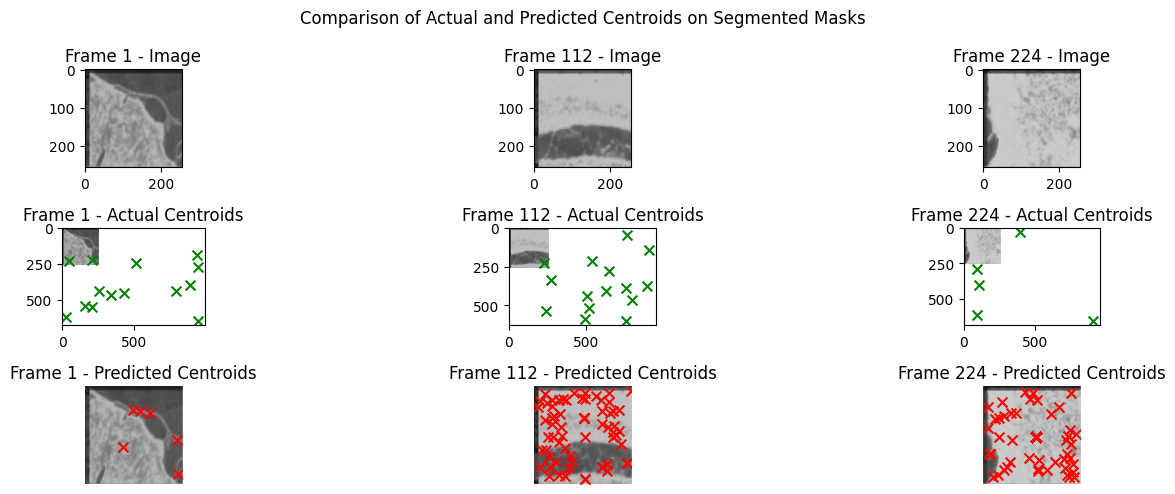

In [ ]:
# Function to visualize centroids on frames
def visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        pred_centroids = tracked_centroids[frame_idx]
        true_centroids = true_centroids_list[frame_idx]

        # Plot the actual segmented mask (image)
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Image')

        # Plot the actual centroids
        plt.subplot(3, num_frames, i + num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Actual Centroids')
        if true_centroids:
            true_centroids_x = [c[0] for c in true_centroids]
            true_centroids_y = [c[1] for c in true_centroids]
            plt.scatter(true_centroids_x, true_centroids_y, color='green', s=50, marker='x', label='Actual Centroid')

        # Plot the predicted centroids
        plt.subplot(3, num_frames, i + 2 * num_frames + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1} - Predicted Centroids')
        if pred_centroids:
            pred_centroids_x = [c[0] for c in pred_centroids]
            pred_centroids_y = [c[1] for c in pred_centroids]
            plt.scatter(pred_centroids_x, pred_centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Comparison of Actual and Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
tracked_centroids = []

for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if frame_idx == 0:
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        matched_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(matched_centroids)

# Visualize 3 selected frames with actual and predicted centroids
visualize_centroids(segmented_masks, tracked_centroids, true_centroids_list, num_frames=3)